In [7]:
import pathlib
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [8]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("Skin/Train")
data_dir_test = pathlib.Path("Skin/Test")

In [9]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

1023
64


**Data Visualization**

Found 1023 files belonging to 4 classes.


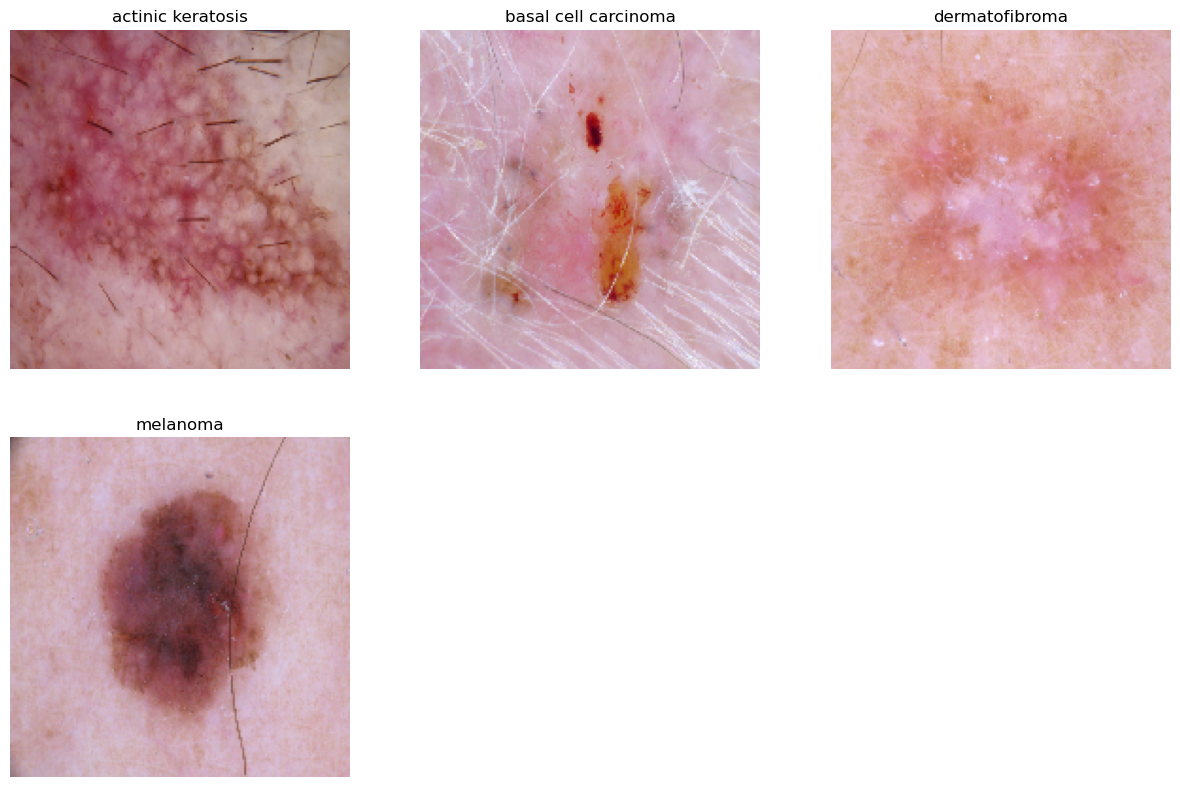

In [10]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [11]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438


<Axes: xlabel='No. of Image', ylabel='Class'>

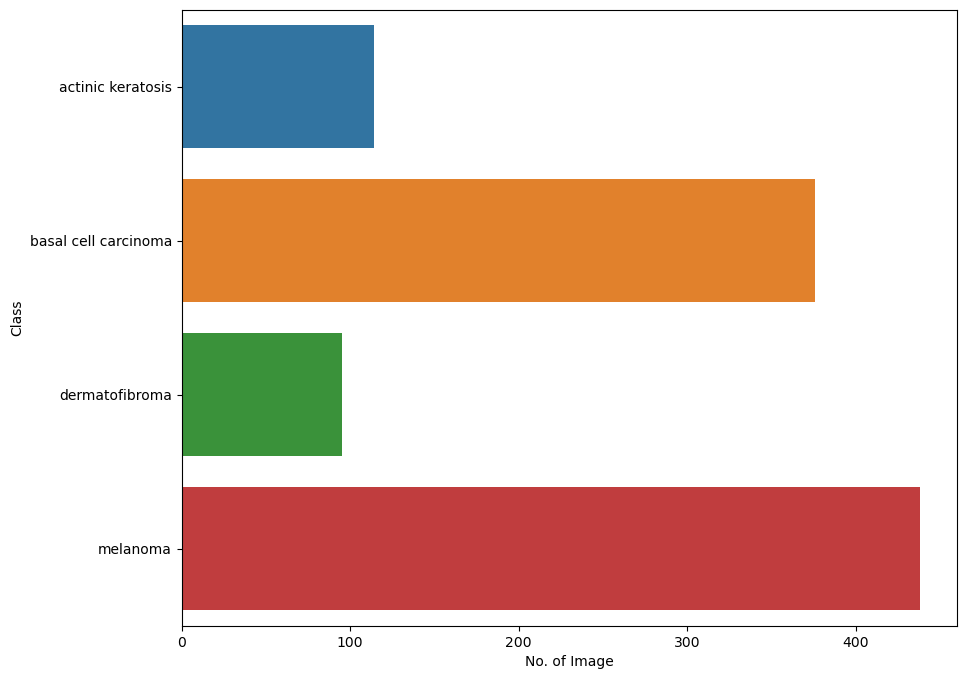

In [12]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [13]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)


Found 1023 files belonging to 4 classes.
Using 819 files for training.
Found 1023 files belonging to 4 classes.
Using 204 files for validation.


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

In [16]:
# vizualizing the model 
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [16]:
# Train the model
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5
26/26 [==============================] - 77s 3s/step - loss: 0.2972 - accuracy: 0.8926 - val_loss: 0.8333 - val_accuracy: 0.7500
Epoch 2/5
26/26 [==============================] - 81s 3s/step - loss: 0.3305 - accuracy: 0.8681 - val_loss: 0.9982 - val_accuracy: 0.7549
Epoch 3/5
26/26 [==============================] - 78s 3s/step - loss: 0.3507 - accuracy: 0.8706 - val_loss: 0.9791 - val_accuracy: 0.7598
Epoch 4/5
26/26 [==============================] - 73s 3s/step - loss: 0.3648 - accuracy: 0.8742 - val_loss: 0.9774 - val_accuracy: 0.7402
Epoch 5/5
26/26 [==============================] - 73s 3s/step - loss: 0.2608 - accuracy: 0.9060 - val_loss: 0.8523 - val_accuracy: 0.7647


In [ ]:
import tensorflow as tf
from keras.models import load_model
model.save('model1.h5')

In [18]:
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Load the saved model
loaded_model = load_model('model.h5')

# Compile the loaded model with appropriate metrics
loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you have a validation dataset (val_ds) prepared as mentioned in your code

# Make predictions on the validation dataset
predictions = loaded_model.predict(val_ds)

# Convert one-hot encoded labels to integer labels
y_true = tf.concat([y for x, y in val_ds], axis=0)
y_true = tf.argmax(y_true, axis=1)

# Convert the predicted probabilities to integer labels
y_pred = tf.argmax(predictions, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


7/7 [==============================] - 6s 787ms/step
Precision: 0.9155
Recall: 0.7402
F1 Score: 0.7889


In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'actinic keratosis')

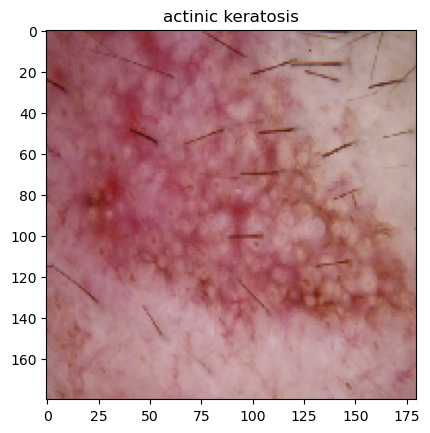

In [5]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
#Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob('upload/1 (1).jpg')
Test_image = load_img(Test_image[-1],target_size=(180,180))
plt.imshow(Test_image)
plt.grid(False)
model=load_model('model.h5')
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
#pred_class = class_names[pred]
if pred==0:
    res='actinic keratosis'
elif pred==1:
    res='basal cell carcinoma'
elif pred==2:
    res='dermatofibroma'
elif pred==3:
    res='melanoma'
plt.title(res)

1/1 [==============================] - 0s 239ms/step
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


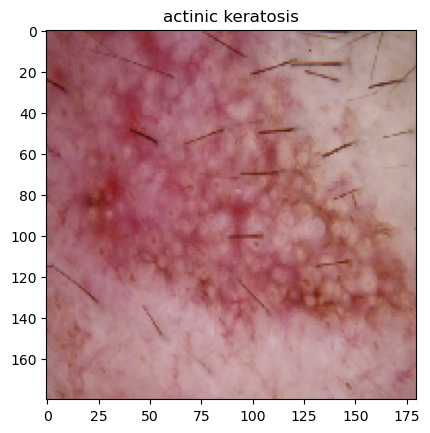

In [6]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have ground truth labels for your test images
true_labels = np.array([0])  # Replace this with your actual ground truth labels

Test_image = glob('upload/1 (1).jpg')
Test_image = load_img(Test_image[-1], target_size=(180, 180))

plt.imshow(Test_image)
plt.grid(False)

model = load_model('model.h5')
img = np.expand_dims(Test_image, axis=0)
pred = model.predict(img)
pred = np.argmax(pred)

# Map the predicted class to the corresponding class name
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma']
pred_class = class_names[pred]

plt.title(pred_class)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, [pred])
recall = recall_score(true_labels, [pred])
f1 = f1_score(true_labels, [pred])

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

plt.show()